# Student Mark prediction

In [299]:
import os.path
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold,cross_validate
from sklearn.metrics import r2_score, mean_squared_error,make_scorer
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.simplefilter('ignore')

In [137]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lainguyn123/student-performance-factors")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Петро\.cache\kagglehub\datasets\lainguyn123\student-performance-factors\versions\6


In [138]:
ds = pd.read_csv(path+"\StudentPerformanceFactors.csv" )
ds.columns = ds.columns.str.lower()

## data shapes

In [139]:
print('columns count - ',len(ds.columns), '\n')
print('columns: ',list(ds.columns))

columns count -  20 

columns:  ['hours_studied', 'attendance', 'parental_involvement', 'access_to_resources', 'extracurricular_activities', 'sleep_hours', 'previous_scores', 'motivation_level', 'internet_access', 'tutoring_sessions', 'family_income', 'teacher_quality', 'school_type', 'peer_influence', 'physical_activity', 'learning_disabilities', 'parental_education_level', 'distance_from_home', 'gender', 'exam_score']


In [140]:
print('Samples count: ',ds.shape[0])

Samples count:  6607


In [141]:
display(ds.head(5))

,hours_studied,attendance,parental_involvement,access_to_resources,extracurricular_activities,sleep_hours,previous_scores,motivation_level,internet_access,tutoring_sessions,family_income,teacher_quality,school_type,peer_influence,physical_activity,learning_disabilities,parental_education_level,distance_from_home,gender,exam_score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [142]:
missing = list()
for x in ds.columns:
    if ds[x].isnull().sum() != 0:
        print(x, ds[x].isnull().sum())
        missing.append(x)

teacher_quality 78
parental_education_level 90
distance_from_home 67


In [143]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   hours_studied               6607 non-null   int64 
 1   attendance                  6607 non-null   int64 
 2   parental_involvement        6607 non-null   object
 3   access_to_resources         6607 non-null   object
 4   extracurricular_activities  6607 non-null   object
 5   sleep_hours                 6607 non-null   int64 
 6   previous_scores             6607 non-null   int64 
 7   motivation_level            6607 non-null   object
 8   internet_access             6607 non-null   object
 9   tutoring_sessions           6607 non-null   int64 
 10  family_income               6607 non-null   object
 11  teacher_quality             6529 non-null   object
 12  school_type                 6607 non-null   object
 13  peer_influence              6607 non-null   obje

In [144]:
ds.describe(include='O')

,parental_involvement,access_to_resources,extracurricular_activities,motivation_level,internet_access,family_income,teacher_quality,school_type,peer_influence,learning_disabilities,parental_education_level,distance_from_home,gender
count,6607,6607,6607,6607,6607,6607,6529,6607,6607,6607,6517,6540,6607
unique,3,3,2,3,2,3,3,2,3,2,3,3,2
top,Medium,Medium,Yes,Medium,Yes,Low,Medium,Public,Positive,No,High School,Near,Male
freq,3362,3319,3938,3351,6108,2672,3925,4598,2638,5912,3223,3884,3814


In [145]:
ds.describe(exclude='O')

,hours_studied,attendance,sleep_hours,previous_scores,tutoring_sessions,physical_activity,exam_score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


## eda

### numerical

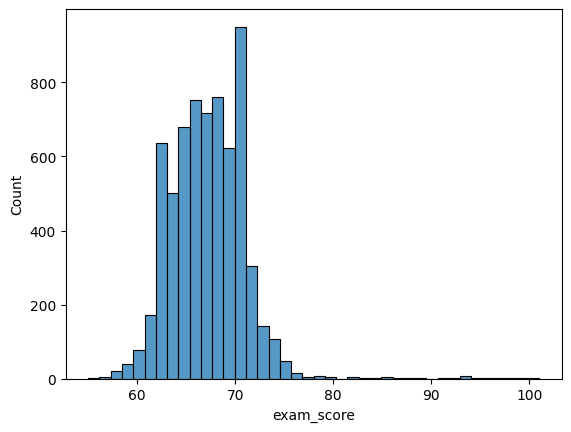

In [146]:
sns.histplot(ds.exam_score, bins=40)

plt.show()

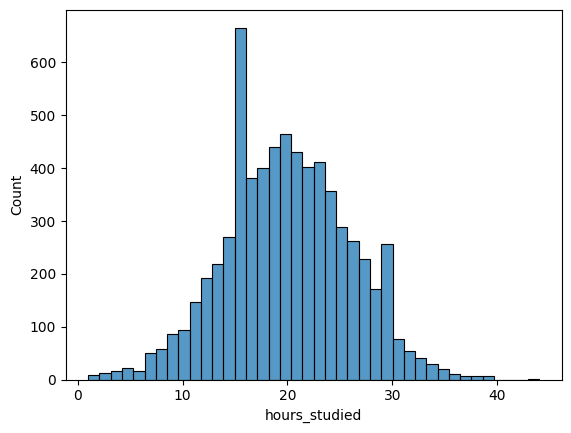

In [147]:
sns.histplot(ds.hours_studied, bins=40)

plt.show()

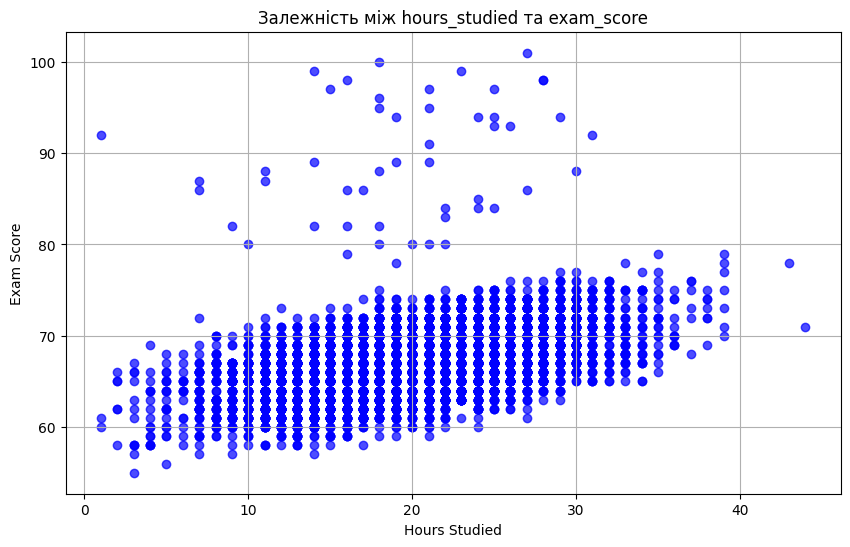

In [148]:
# Побудова графіка залежності між Hours_Studied та Exam_Score
plt.figure(figsize=(10, 6))
plt.scatter(ds['hours_studied'], ds['exam_score'], color='blue', alpha=0.7)
plt.title('Залежність між hours_studied та exam_score')
plt.xlabel('Hours Studied')
plt.ylabel('Exam Score')
plt.grid(True)
plt.show()

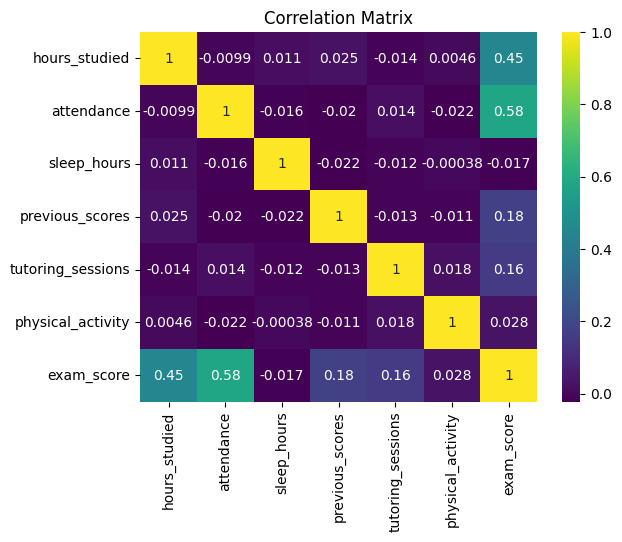

In [149]:
numerical_cols = ds.select_dtypes('number').columns
corr_matrix = ds[numerical_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='viridis')

plt.title('Correlation Matrix')

plt.show()

### categorial

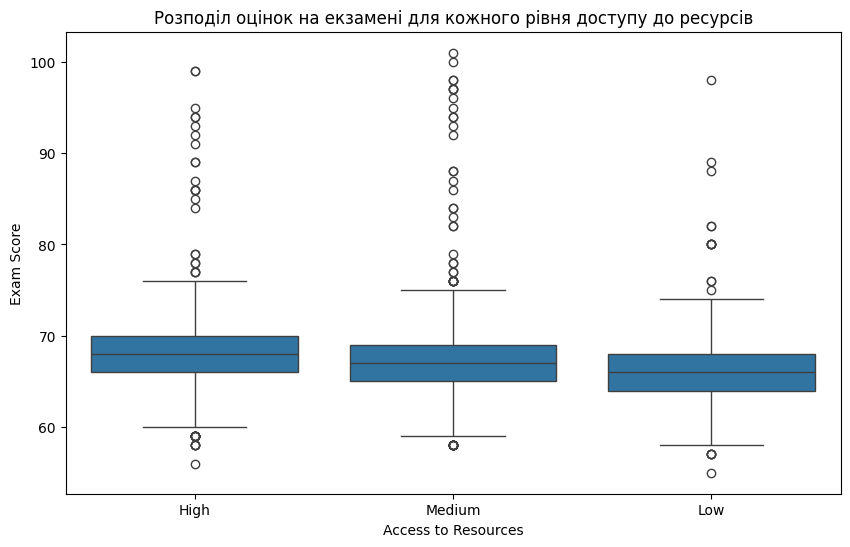

In [150]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=ds, x='access_to_resources', y='exam_score')

# Налаштування графіку
plt.title('Розподіл оцінок на екзамені для кожного рівня доступу до ресурсів')
plt.xlabel('Access to Resources')
plt.ylabel('Exam Score')
plt.show()

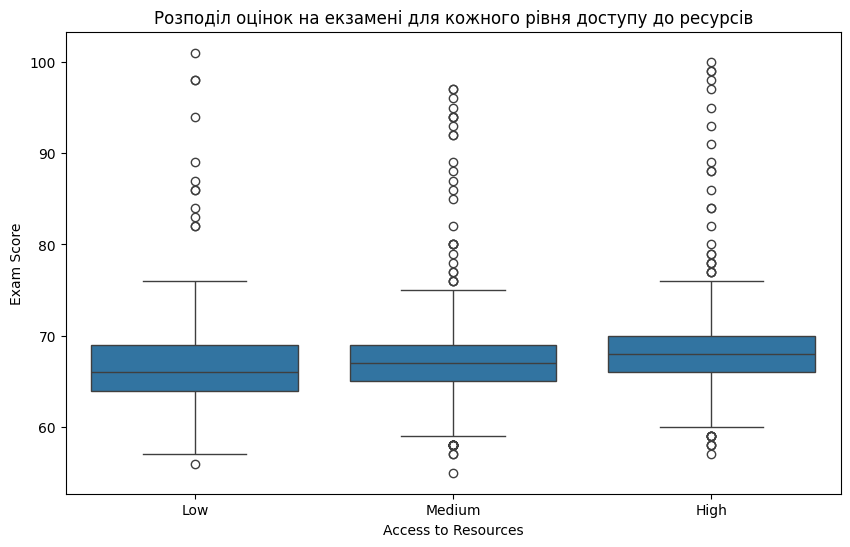

In [151]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=ds, x='parental_involvement', y='exam_score')

# Налаштування графіку
plt.title('Розподіл оцінок на екзамені для кожного рівня доступу до ресурсів')
plt.xlabel('Access to Resources')
plt.ylabel('Exam Score')
plt.show()

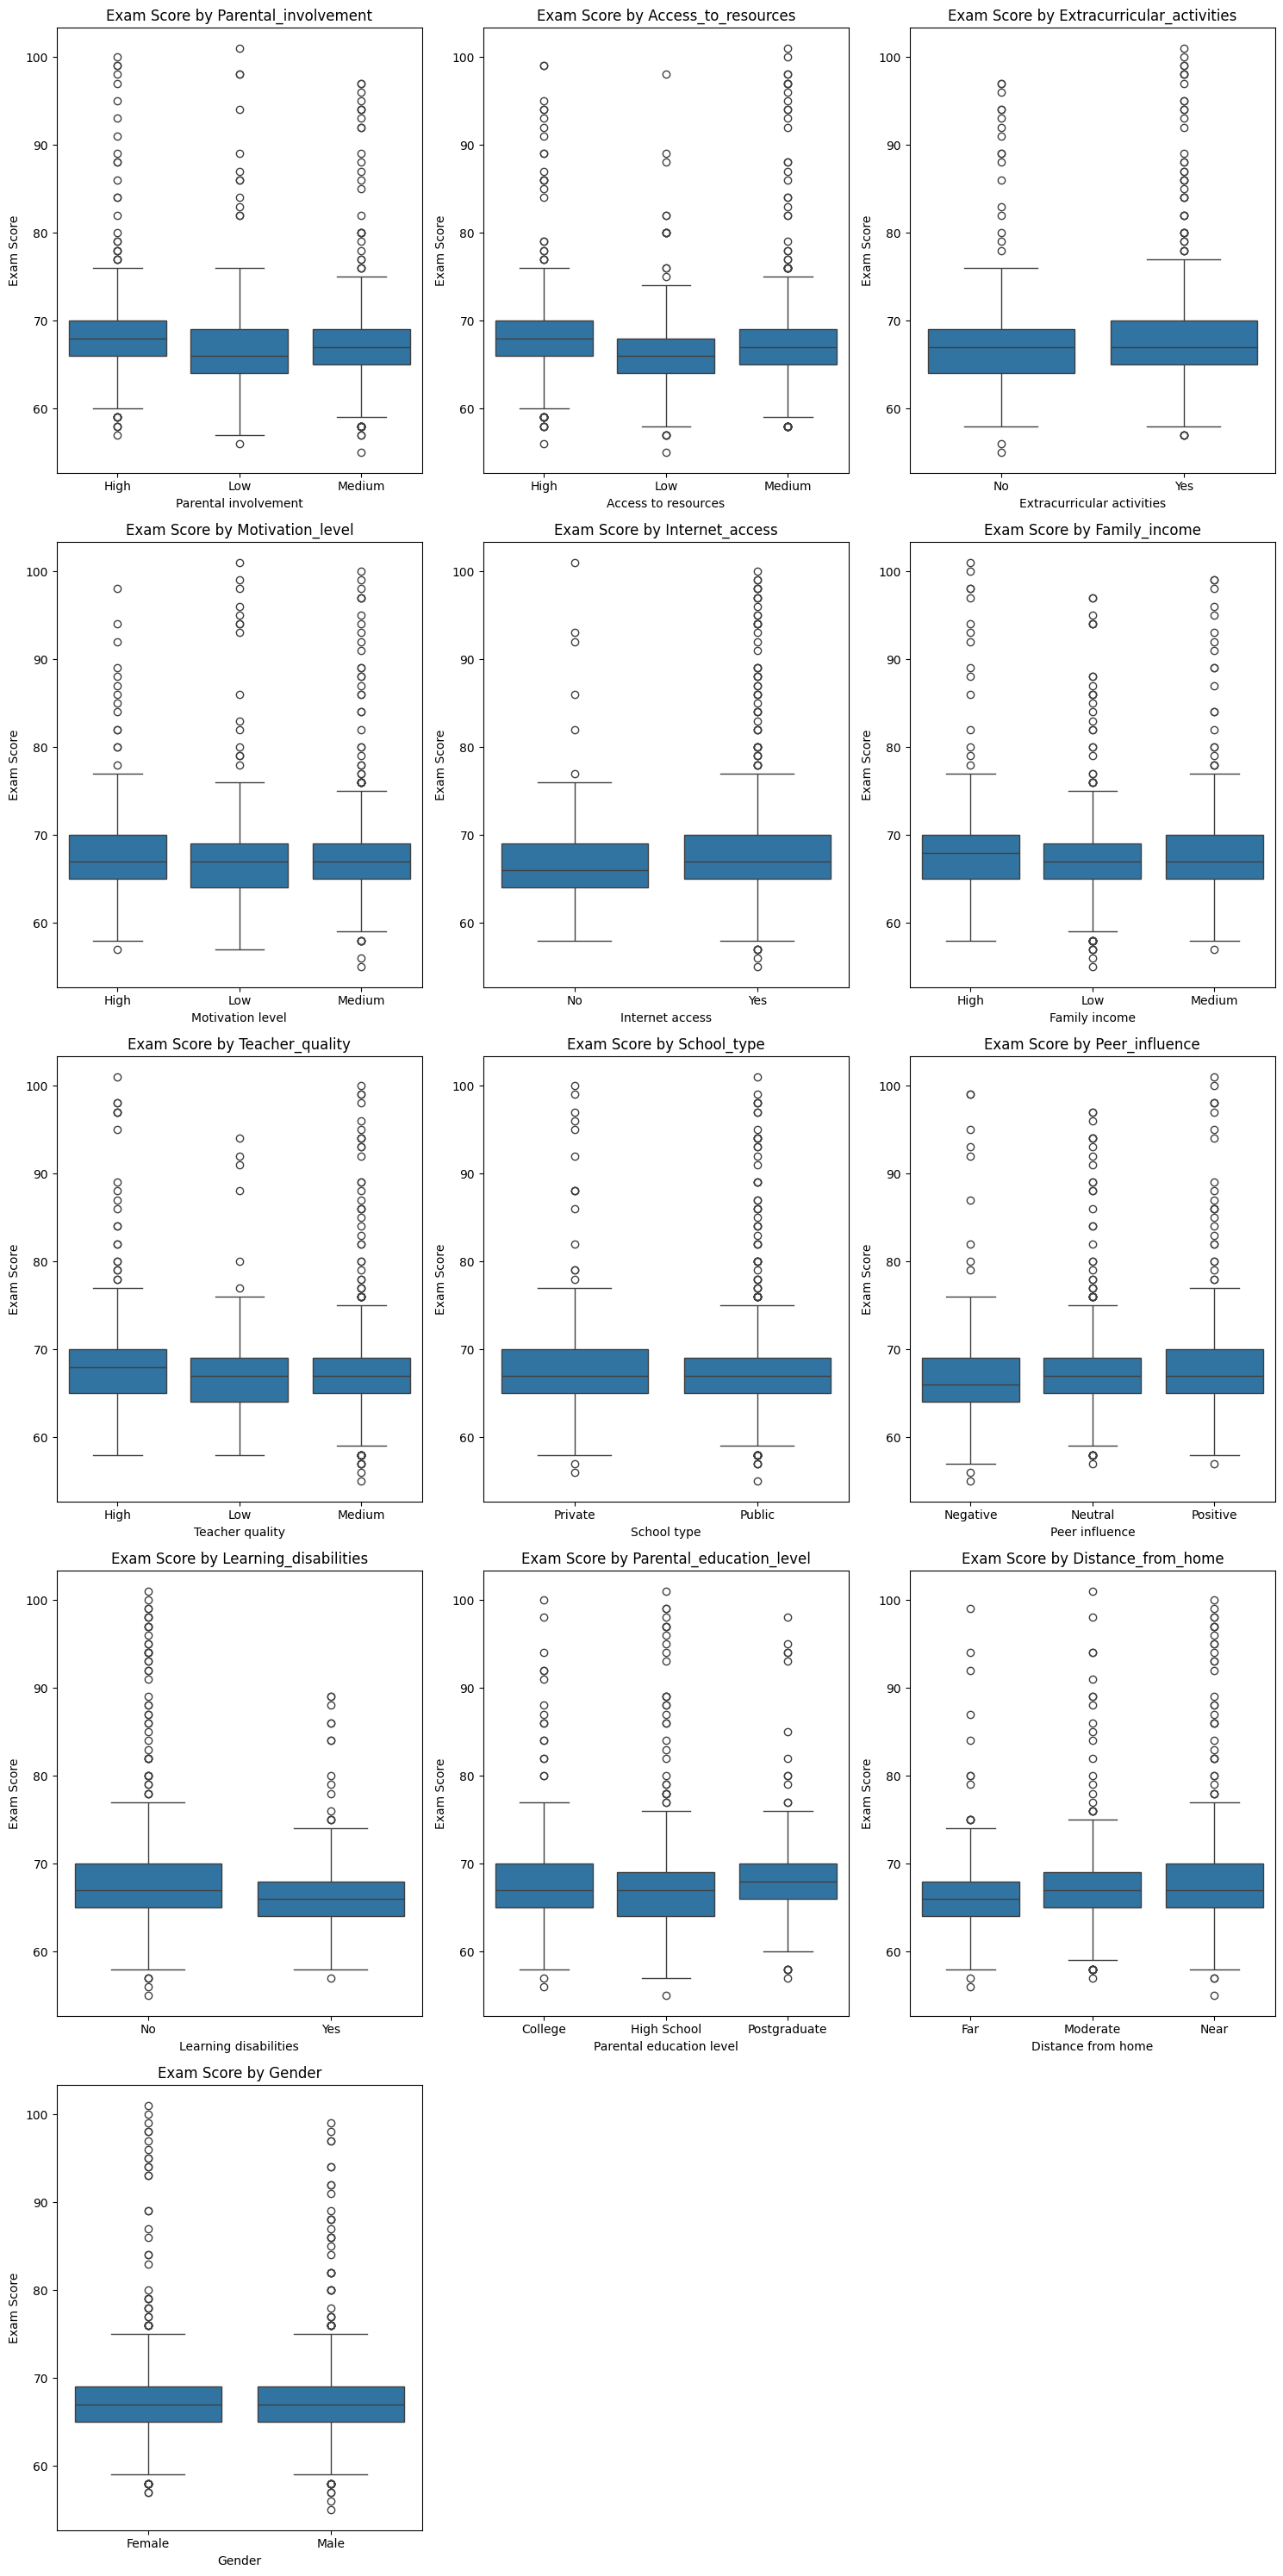

In [152]:
categorical_columns = [col for col in ds.columns if ds[col].dtype == 'object' or ds[col].dtype.name == 'category']

# Переводимо знайдені змінні в тип 'category'
for col in categorical_columns:
    ds[col] = ds[col].astype('category')

# Перевірка, чи є категоріальні змінні
if categorical_columns:
    # Визначаємо кількість стовпців і рядків для subplot
    num_cols = 3  # Кількість графіків на рядок
    num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Вираховуємо необхідну кількість рядків

    plt.figure(figsize=(num_cols * 5, num_rows * 6))  # Налаштовуємо розмір фігури

    # Створюємо субплоти
    for i, col in enumerate(categorical_columns, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.boxplot(data=ds, x=col, y='exam_score')
        plt.title(f'Exam Score by {col.capitalize()}')
        plt.xlabel(col.replace('_', ' ').capitalize())
        plt.ylabel('Exam Score')

    plt.tight_layout()
    plt.show()
else:
    print("Немає категоріальних змінних для побудови графіків.")

## future enginiring

### mising 

In [153]:
missing = list()
for x in ds.columns:
    if ds[x].isnull().sum() != 0:
        print(x, ds[x].isnull().sum())
        missing.append(x)

teacher_quality 78
parental_education_level 90
distance_from_home 67


Зважаючи що всі значення категоріальні замінюємо їх на моду

In [ ]:
for col in ['teacher_quality', 'parental_education_level', 'distance_from_home']:
    mode_value = ds[col].mode()[0]  # Знаходимо моду для кожного стовпця
    ds[col].fillna(mode_value, inplace=True)  # Замінюємо пропущені значення на моду

### anomaly

In [155]:
def diagnostic_plots(df, variable):
    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [156]:
ds.describe()

,hours_studied,attendance,sleep_hours,previous_scores,tutoring_sessions,physical_activity,exam_score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


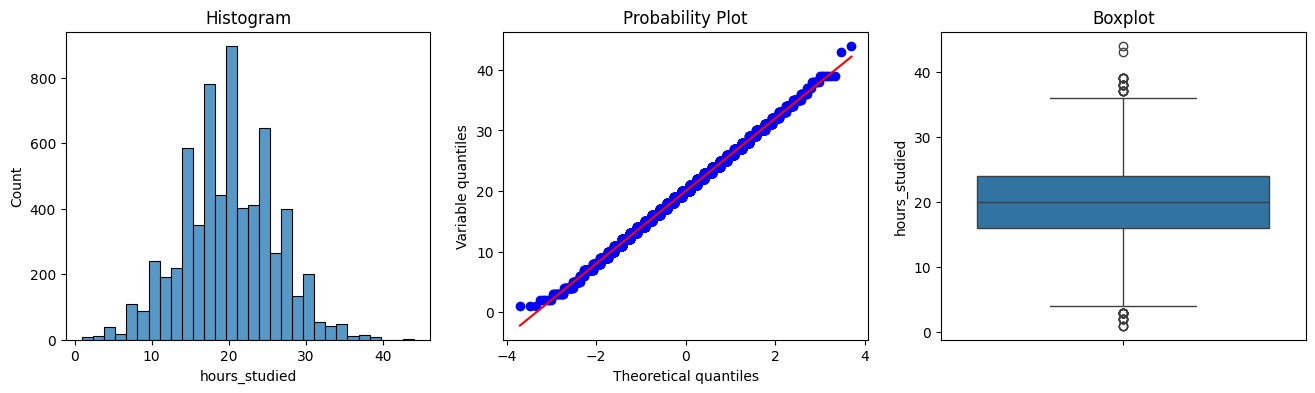

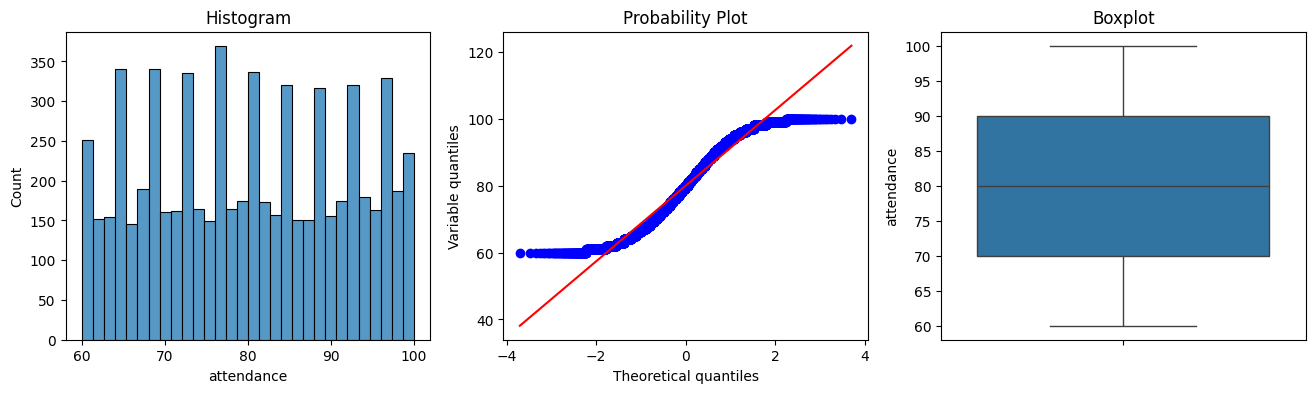

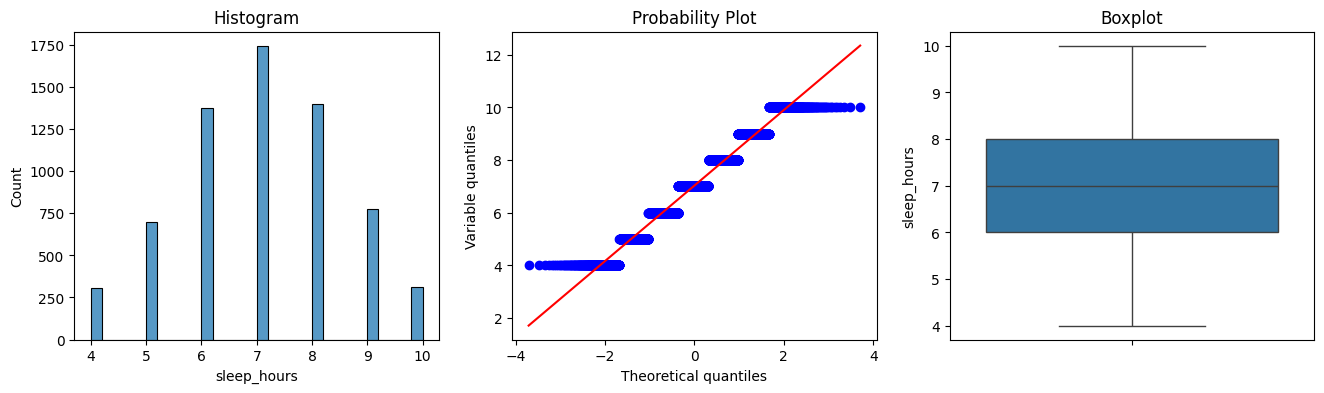

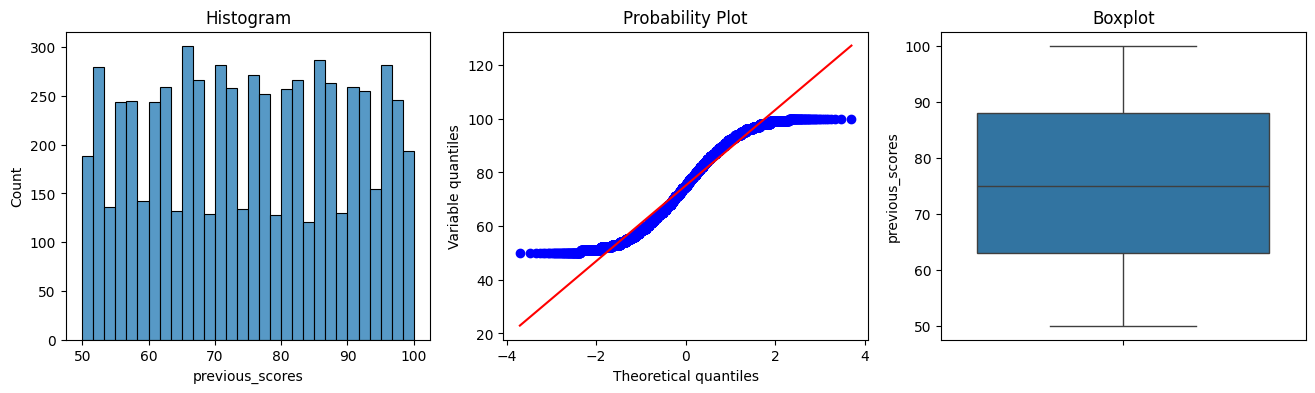

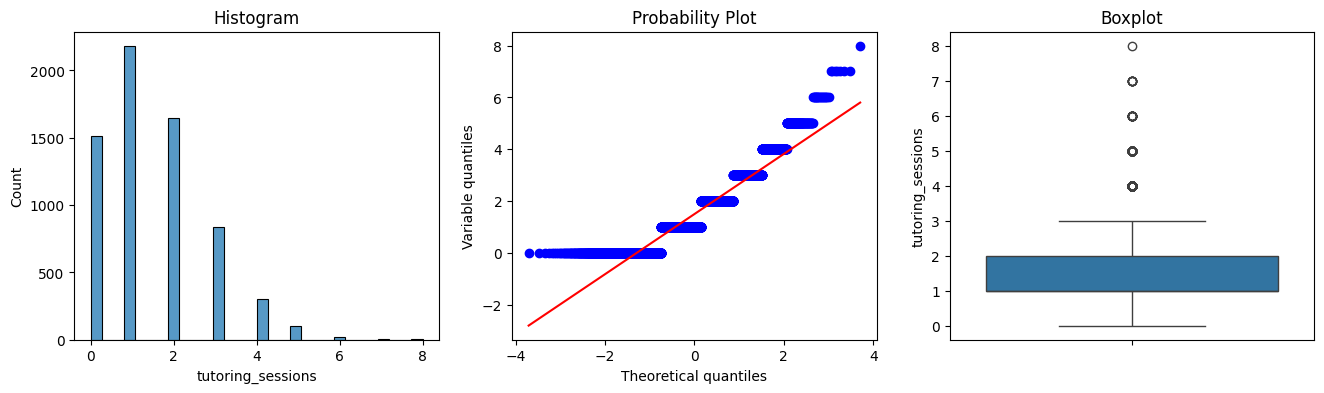

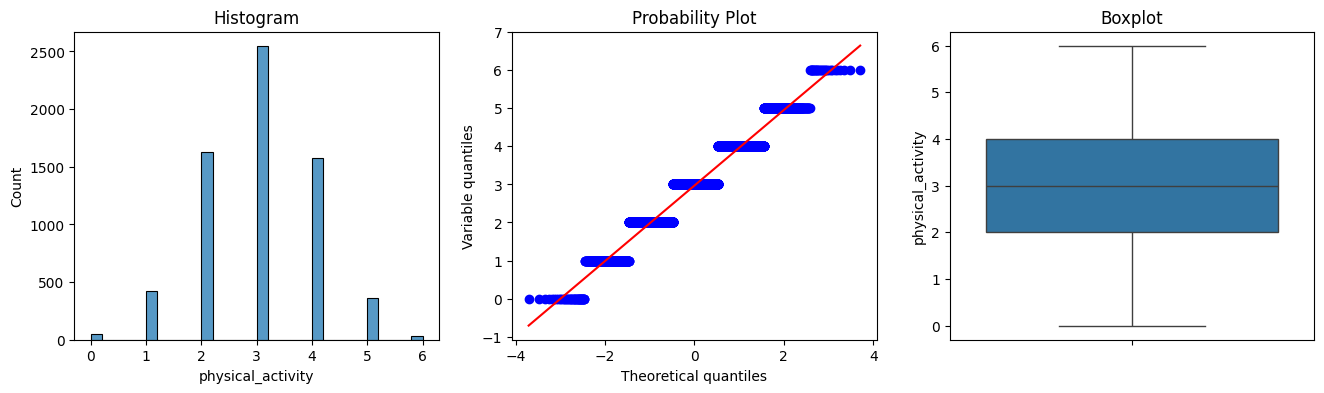

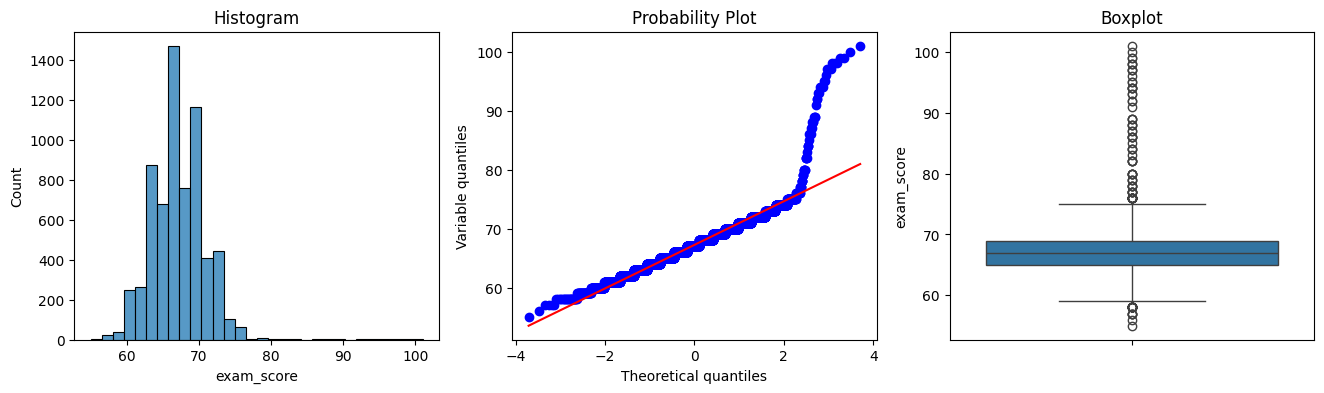

In [157]:
diagnostic_plots(ds, 'hours_studied')
diagnostic_plots(ds, 'attendance')
diagnostic_plots(ds, 'sleep_hours')
diagnostic_plots(ds, 'previous_scores')
diagnostic_plots(ds, 'tutoring_sessions')
diagnostic_plots(ds, 'physical_activity')
diagnostic_plots(ds, 'exam_score')

In [158]:
def delete_anomalies(df, variable, distance=3):
    # Розрахунок меж на основі IQR
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    # Визначення аномалій
    anomaly_flags = np.where(df[variable] > upper_boundary, True,
                             np.where(df[variable] < lower_boundary, True, False))
    # Фільтрація набору даних, видаляючи аномалії
    df_filtered = df.loc[~anomaly_flags, :]

    # Виведення результатів
    print(f'Original shape: {df.shape}, Filtered shape: {df_filtered.shape}')
    print(f'{ds.shape[0] - df_filtered.shape[0]} outliers removed')

    return df_filtered
import numpy as np

def replace_anomalies(df, variable, distance=3):
    # Розрахунок меж на основі IQR
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    # Замінюємо значення, що перевищують верхню межу, на верхню межу
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                            np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))
    
    return df

In [159]:
ds=delete_anomalies(ds,'tutoring_sessions',4)

# Видаляємо рядки, де значення 'exam_score' більше 100
ds = ds[ds['exam_score'] <= 100].reset_index(drop=True)

Original shape: (6607, 20), Filtered shape: (6599, 20)
8 outliers removed


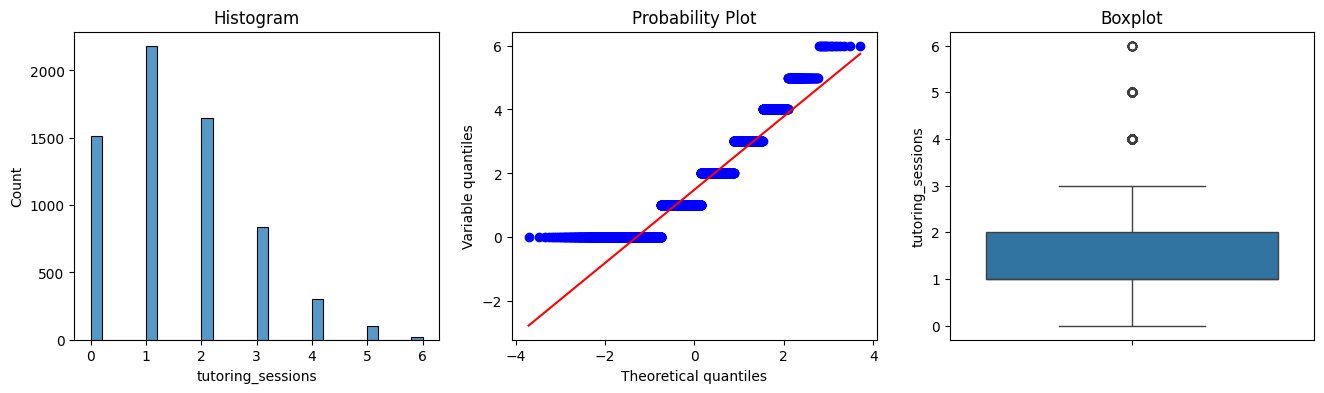

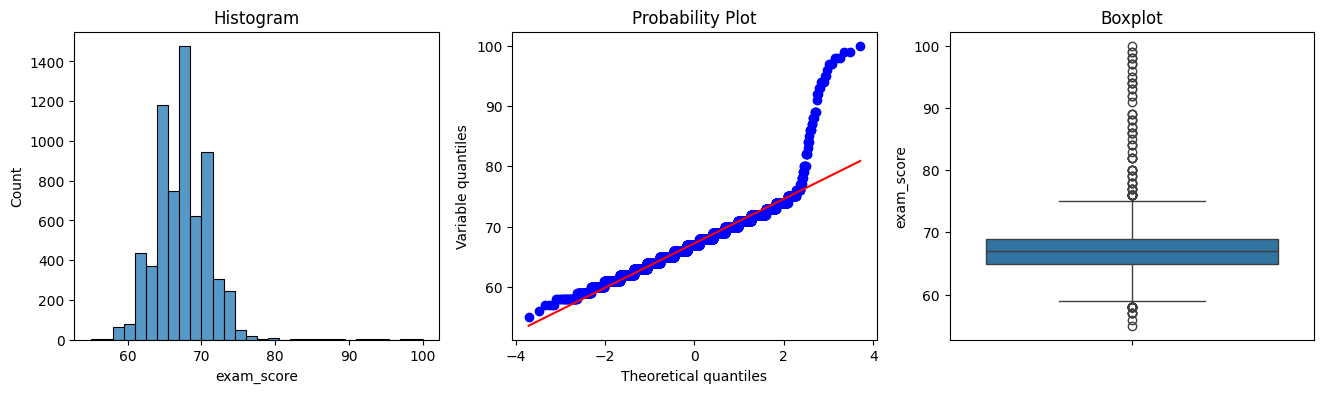

In [160]:
diagnostic_plots(ds, 'tutoring_sessions')
diagnostic_plots(ds, 'exam_score')

### categorial encoding


In [161]:
display(ds.dtypes)

hours_studied                    int64
attendance                       int64
parental_involvement          category
access_to_resources           category
extracurricular_activities    category
sleep_hours                      int64
previous_scores                  int64
motivation_level              category
internet_access               category
tutoring_sessions                int64
family_income                 category
teacher_quality               category
school_type                   category
peer_influence                category
physical_activity                int64
learning_disabilities         category
parental_education_level      category
distance_from_home            category
gender                        category
exam_score                       int64
dtype: object

In [178]:
mapping_dict = {
    'Positive': 2, 'Negative': 0,'Neutral':1,
    'Yes': 1, 'No': 0,
    'Low': 0, 'Medium': 1, 'High': 2,
    'Private': 1, 'Public': 0,
    'Near': 2, 'Moderate': 1, 'Far': 0,
    'High School': 0, 'College': 1, 'Postgraduate': 2,
    'Male': 0, 'Female': 1,
    0: 0, 1: 1, 2: 2  # Додаємо заміну для 0, 1, 2
}

In [179]:
ds.replace(mapping_dict, inplace=True)

In [186]:
ds=ds.astype(int)
display(ds.dtypes)

hours_studied                 int32
attendance                    int32
parental_involvement          int32
access_to_resources           int32
extracurricular_activities    int32
sleep_hours                   int32
previous_scores               int32
motivation_level              int32
internet_access               int32
tutoring_sessions             int32
family_income                 int32
teacher_quality               int32
school_type                   int32
peer_influence                int32
physical_activity             int32
learning_disabilities         int32
parental_education_level      int32
distance_from_home            int32
gender                        int32
exam_score                    int32
dtype: object

### Normalization


In [201]:
fields = [
    'hours_studied', 
    'attendance', 
    'access_to_resources', 
    'sleep_hours', 
    'previous_scores', 
    'tutoring_sessions', 
    'teacher_quality', 
    'physical_activity', 
    'parental_education_level', 
    'distance_from_home',
    'parental_involvement',
    'motivation_level',
    'family_income'

]
display(ds.head())

,hours_studied,attendance,parental_involvement,access_to_resources,extracurricular_activities,sleep_hours,previous_scores,motivation_level,internet_access,tutoring_sessions,family_income,teacher_quality,school_type,peer_influence,physical_activity,learning_disabilities,parental_education_level,distance_from_home,gender,exam_score
0,0.511628,0.600,0,1.0,0,0.500000,0.46,0,1,0.000000,0,0.5,0,1,0.500000,0,0.0,1.0,0,67
1,0.418605,0.100,0,0.5,0,0.666667,0.18,0,1,0.333333,1,0.5,0,0,0.666667,0,0.5,0.5,1,61
2,0.534884,0.950,1,0.5,1,0.500000,0.82,1,1,0.333333,1,0.5,0,1,0.666667,0,1.0,1.0,0,74
3,0.651163,0.725,0,0.5,1,0.666667,0.96,1,1,0.166667,1,0.5,0,0,0.666667,0,0.0,0.5,0,71
4,0.418605,0.800,1,0.5,1,0.333333,0.30,1,1,0.500000,1,1.0,0,1,0.666667,0,0.5,1.0,1,70


In [202]:
scaler = MinMaxScaler()

# Нормалізація даних
ds[fields] = scaler.fit_transform(ds[fields])

# Створення нового DataFrame з тими ж колонками
ds = pd.DataFrame(ds, columns=ds.columns)
display(ds.head())

,hours_studied,attendance,parental_involvement,access_to_resources,extracurricular_activities,sleep_hours,previous_scores,motivation_level,internet_access,tutoring_sessions,family_income,teacher_quality,school_type,peer_influence,physical_activity,learning_disabilities,parental_education_level,distance_from_home,gender,exam_score
0,0.511628,0.600,0.0,1.0,0,0.500000,0.46,0.0,1,0.000000,0.0,0.5,0,1,0.500000,0,0.0,1.0,0,67
1,0.418605,0.100,0.0,0.5,0,0.666667,0.18,0.0,1,0.333333,0.5,0.5,0,0,0.666667,0,0.5,0.5,1,61
2,0.534884,0.950,0.5,0.5,1,0.500000,0.82,0.5,1,0.333333,0.5,0.5,0,1,0.666667,0,1.0,1.0,0,74
3,0.651163,0.725,0.0,0.5,1,0.666667,0.96,0.5,1,0.166667,0.5,0.5,0,0,0.666667,0,0.0,0.5,0,71
4,0.418605,0.800,0.5,0.5,1,0.333333,0.30,0.5,1,0.500000,0.5,1.0,0,1,0.666667,0,0.5,1.0,1,70


## Model choosing

In [223]:



X = ds.drop('exam_score', axis=1)
y = ds['exam_score']

# Розділяємо дані на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Створюємо список моделей для регресії
# Список моделей
models = {
    'Лінійна регресія': LinearRegression(),
    'Випадковий ліс': RandomForestRegressor(random_state=42),
    'Градієнтний бустинг': GradientBoostingRegressor(random_state=42),
    'Lasso регресія': Lasso(alpha=0.1),
    'Ridge регресія': Ridge(alpha=0.1),
    'ElasticNet регресія': ElasticNet(alpha=0.1, l1_ratio=0.7),
    'SVR регресія': SVR(kernel='rbf'),
    'MLP регресія': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Навчання та оцінка кожної моделі
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - MSE: {mse}, R^2: {r2}")


Лінійна регресія - MSE: 2.488797936410338, R^2: 0.8088853876665535
Випадковий ліс - MSE: 3.8046104545454544, R^2: 0.7078442402001616
Градієнтний бустинг - MSE: 2.846456567970046, R^2: 0.7814208073893643
Lasso регресія - MSE: 4.075549821589833, R^2: 0.6870388259312795
Ridge регресія - MSE: 2.4883781807055705, R^2: 0.8089176206765611
ElasticNet регресія - MSE: 5.428986914945695, R^2: 0.583108490073043
SVR регресія - MSE: 2.6157495845936602, R^2: 0.7991367798456059
MLP регресія - MSE: 2.519506515751721, R^2: 0.8065272780947479


In [220]:
X = ds.drop('exam_score', axis=1)
y = ds['exam_score']

# Створюємо список моделей для регресії
models = {
    'Лінійна регресія': LinearRegression(),
    'Випадковий ліс': RandomForestRegressor(random_state=42),
    'Градієнтний бустинг': GradientBoostingRegressor(random_state=42),
    'Lasso регресія': Lasso(alpha=0.1),
    'Ridge регресія': Ridge(alpha=0.1),
    'ElasticNet регресія': ElasticNet(alpha=0.1, l1_ratio=0.7),
    'SVR регресія': SVR(kernel='rbf'),
    'MLP регресія': MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Визначаємо кількість фолдів для k-fold валідації
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Навчання та оцінка кожної моделі за допомогою k-fold cross-validation
for model_name, model in models.items():
    # Використовуємо перехресну валідацію для оцінки моделі
    mse_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfold)
    r2_scores = cross_val_score(model, X, y, scoring='r2', cv=kfold)

    # Перетворюємо MSE на позитивні значення (оскільки cross_val_score повертає негативне значення MSE)
    mse_scores = -mse_scores

    # Виведемо середні значення MSE та R²
    print(f"{model_name} - MSE: {mse_scores.mean()}, R^2: {r2_scores.mean()}")

Лінійна регресія - MSE: 4.1066712868145645, R^2: 0.7335519988779852
Випадковий ліс - MSE: 5.492751692489719, R^2: 0.63990242790618
Градієнтний бустинг - MSE: 4.658049255879834, R^2: 0.696875215326235
Lasso регресія - MSE: 5.976271975396084, R^2: 0.6074998523229717
Ridge регресія - MSE: 4.106666688580374, R^2: 0.733552748078697
ElasticNet регресія - MSE: 7.338140317479045, R^2: 0.5153279699213119
SVR регресія - MSE: 4.260946845009589, R^2: 0.7230124516885006
MLP регресія - MSE: 4.151972594293836, R^2: 0.7303731227925058


Лінійна регресія - MSE: 4.1066712868145645, R^2: 0.7335519988779852

Ridge регресія - MSE: 4.106666688580374, R^2: 0.733552748078697



## Hiperparams choose

In [ ]:
rm=Ridge(alpha=0.1)
display(rm.get_params())


{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [283]:

param_dist = {
    'alpha': np.logspace(-6, 6, 30),  # Більш широкий діапазон значень alpha на логарифмічній шкалі
    'copy_X': [True, False],  # Чи копіювати X при тренуванні
    'fit_intercept': [True, False],  # Чи включати вільний член (intercept)
    'max_iter': [None, 100, 200, 500, 1000, 2000],  # Різні варіанти для кількості ітерацій
    'positive': [False, True],  # Чи застосовувати позитивні коефіцієнти
    'random_state': [None, 42, 123, 7],  # Встановлення random_state для відтворюваності
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga', 'lbfgs'],  # Алгоритми розв'язання рівняння
    'tol': [1e-4, 1e-3, 1e-2, 1e-1, 1e-5, 1e-6]  # Різні допустимі похибки
}
# Модель
ridge = Ridge()

# Розділяємо дані на X (ознаки) та y (мітка)
X = ds.drop('exam_score', axis=1)
y = ds['exam_score']

# RandomizedSearchCV для пошуку оптимальних параметрів
random_search = RandomizedSearchCV(ridge,
                                    param_distributions=param_dist,
                                    n_iter=500,
                                    cv=25,
                                    scoring='neg_mean_squared_error',
                                    random_state=42,
                                    verbose = 3,
                                    )

# Навчання моделі
random_search.fit(X, y)

# Найкращі параметри
print("Найкращі параметри:", random_search.best_params_)

# Оцінка моделі з найкращими параметрами
print("Найкраща оцінка (R^2):", random_search.best_score_)


Fitting 25 folds for each of 500 candidates, totalling 12500 fits
[CV 1/25] END alpha=10.82636733874054, copy_X=False, fit_intercept=True, max_iter=500, positive=False, random_state=7, solver=saga, tol=0.01;, score=-6.326 total time=   0.0s
[CV 2/25] END alpha=10.82636733874054, copy_X=False, fit_intercept=True, max_iter=500, positive=False, random_state=7, solver=saga, tol=0.01;, score=-1.710 total time=   0.0s
[CV 3/25] END alpha=10.82636733874054, copy_X=False, fit_intercept=True, max_iter=500, positive=False, random_state=7, solver=saga, tol=0.01;, score=-9.735 total time=   0.0s
[CV 4/25] END alpha=10.82636733874054, copy_X=False, fit_intercept=True, max_iter=500, positive=False, random_state=7, solver=saga, tol=0.01;, score=-5.964 total time=   0.0s
[CV 5/25] END alpha=10.82636733874054, copy_X=False, fit_intercept=True, max_iter=500, positive=False, random_state=7, solver=saga, tol=0.01;, score=-6.124 total time=   0.0s
[CV 6/25] END alpha=10.82636733874054, copy_X=False, fit_in

In [ ]:
perfect_hip={
    'tol': 0.01,
    'solver': 'saga', 
    'random_state': 42,
    'positive': False,
    'max_iter': None,
    'fit_intercept': True, 
    'copy_X': False,
    'alpha': 0.005298316906283708}

In [312]:

model=Ridge(alpha=0.1)

X = ds.drop('exam_score', axis=1)
y = ds['exam_score']

# Створення KFold об'єкта для крос-валідації
kf = KFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

results = cross_validate(model, X, y, cv=kf, scoring=scoring)

print(f"Середнє MSE: {np.mean(results['test_mse'])}")
print(f"Середнє R^2: {np.mean(results['test_r2'])}")

Середнє MSE: 4.101019047042103
Середнє R^2: 0.7404580790530706


In [313]:
model=Ridge(**perfect_hip)

X = ds.drop('exam_score', axis=1)
y = ds['exam_score']

# Створення KFold об'єкта для крос-валідації
kf = KFold(n_splits=10, shuffle=True, random_state=42)

scoring = {
    'mse': make_scorer(mean_squared_error),
    'r2': make_scorer(r2_score)
}

results = cross_validate(model, X, y, cv=kf, scoring=scoring)

print(f"Середнє MSE: {np.mean(results['test_mse'])}")
print(f"Середнє R^2: {np.mean(results['test_r2'])}")

Середнє MSE: 4.100860257453886
Середнє R^2: 0.7404695283676465


## feature importance

                       Feature  Coefficient
0                hours_studied    12.668553
1                   attendance     7.913875
9            tutoring_sessions     2.925948
6              previous_scores     2.407707
3          access_to_resources     2.061985
2         parental_involvement     2.016198
14           physical_activity     1.134810
7             motivation_level     1.072185
10               family_income     1.047667
11             teacher_quality     1.044518
16    parental_education_level     0.992788
8              internet_access     0.975170
17          distance_from_home     0.941581
13              peer_influence     0.773500
4   extracurricular_activities     0.562939
18                      gender     0.035735
5                  sleep_hours    -0.007070
12                 school_type    -0.033298
15       learning_disabilities    -0.854058


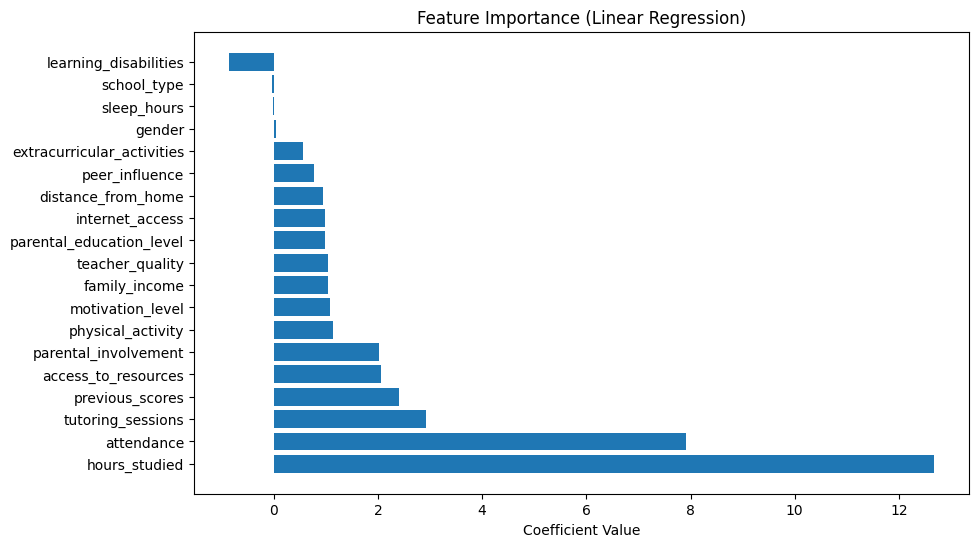

In [316]:
X = ds.drop('exam_score', axis=1)
y = ds['exam_score']
lr = Ridge(**perfect_hip)
lr.fit(X, y)
coefficients = lr.coef_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})
feature_importance_df = feature_importance_df.sort_values(by='Coefficient', ascending=False)
print(feature_importance_df)
plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Linear Regression)')
plt.show()

In [203]:
ds.to_csv('changed.csv', index=False)